In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import pearsonr, ttest_ind
from sklearn.linear_model import LinearRegression

# Set working directory
import os
os.chdir('/Users/jorgegarciacondado/Documents/Projects/AgingBrainStudy/')


In [2]:
# PRS threshold
prs_th = 0.5

# Get dataframe
df_prs = pd.read_csv(f'data/A4/processed/prs_{prs_th}.csv')
prs_types = ['GM', 'WM', 'FC']
prs_cols = ['{}_ZSCORE'.format(prs_type) for prs_type in prs_types]

# Column names of interes
info = ['BID', 'AGEYR', 'SEX']
df_info = pd.read_csv('data/A4/raw/SUBJINFO.csv', usecols=info) 

# Variables of interest
genetics = ['APOEGN']
amyloid = ['Amyloid']
plasma_factors = ['pTau217', 'AB42/AB40', 'GFAP ', 'NF-L ', 'TPP181']
cognition_factors = ['PACC', 'FCTOTAL96', 'LDELTOTAL', 'DIGITTOTAL', 'MMSCORE']
amyloid_factors = ['Composite_Summary', 'lanterior_cingulate_2', 'llposterior_cingulate_2',
                   'lnew_parietal', 'lprecuneus_gm', 'new_temporal_2', 'xlaal_frontal_med_orb']
tau_factors = ['bi_inferiortemporal', 'bi_inferiorparietal', 'bi_fusiform', 'bi_middletemporal', 
               'bi_entorhinal', 'bi_Amygdala', 'bi_parahippocampal', 'bi_Hippocampus']


## Distribution of PRS

Age of subjects: 71.37154611811546 [4.7591416528109285]
Number of subjects: male 1215 (40.311877903118784%), female 1799
Number of subjects by PRS
GM PRS: 3014
WM PRS: 3014
FC PRS: 3014


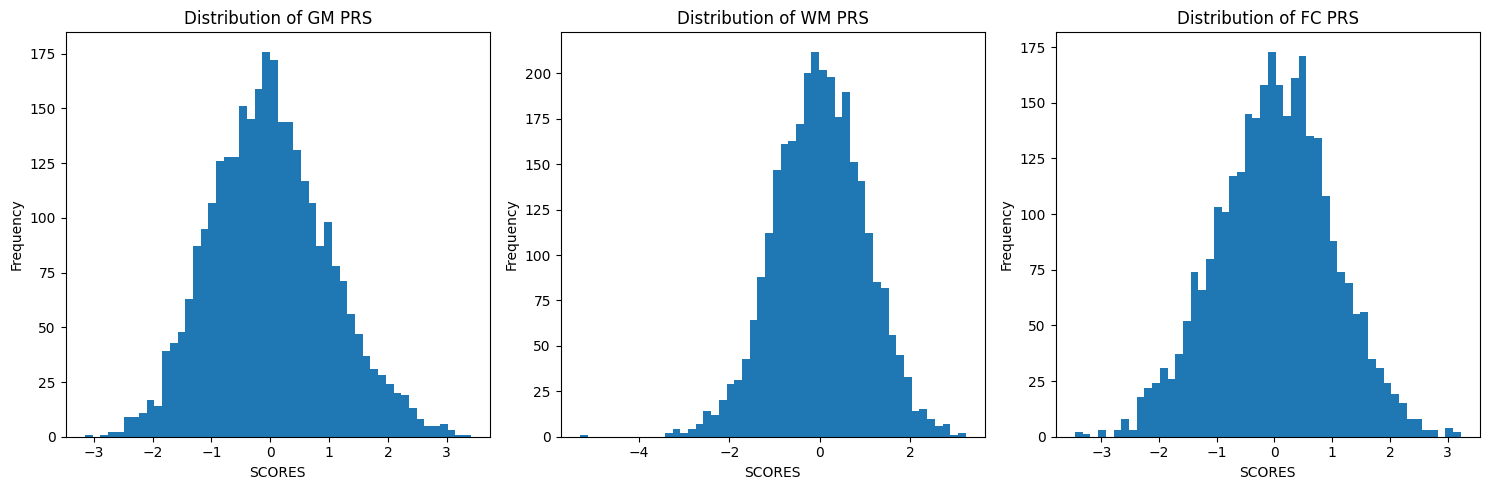

In [3]:
# Age distribution of subjects and sex distribution
df_prs = df_info.merge(df_prs, on='BID')
df_prs = df_prs.copy().dropna()
print('Age of subjects: {} [{}]'.format(df_prs['AGEYR'].mean(), df_prs['AGEYR'].std()))
nmale = len(df_prs[df_prs['SEX']==2])
nfemale = len(df_prs[df_prs['SEX']==1])
print('Number of subjects: male {} ({}%), female {}'.format(nmale, nmale/(nmale+nfemale)*100, nfemale))

# Number of subjects by PRS
print('Number of subjects by PRS')
for prs_type in prs_types:
    print('{} PRS: {}'.format(prs_type, len(df_prs[df_prs['{}_ZSCORE'.format(prs_type)].notnull()])))

# Show distributions of ZSCORES for each prs type
plt.figure(figsize=(15, 5))
for prs_type in prs_types:
    plt.subplot(1, 3, prs_types.index(prs_type) + 1)
    plt.hist(df_prs['{}_ZSCORE'.format(prs_type)], bins=50)
    plt.title('Distribution of {} PRS'.format(prs_type))
    plt.xlabel('SCORES')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Correlation with Plasma measurments

Correlation beetween PRS measures and plasma measurments on residuals corrected by age

In [4]:
# Choos factor type to use
factor_type = 'blood' # 'blood', 'cognition', 'pet_amyloid', 'pet_tau'

if factor_type == 'blood':
    factors = plasma_factors
elif factor_type == 'cognition':
    factors = cognition_factors
elif factor_type == 'pet_amyloid':
    factors = amyloid_factors
elif factor_type == 'pet_tau':
    factors = tau_factors


# Load data
df = pd.read_csv('data/A4/processed/factors.csv')
df = df_prs.merge(df, on='BID', how='outer')

In [5]:
# Calculate Pearson correlation between PRS and different values

# Dataframe to store results
df_factors = pd.DataFrame(columns=['Factor']+ [prs + '_corr' for prs in prs_types]
                          + [prs + '_pval' for prs in prs_types])

# Calculate correlation between PRS and plasma factors
for factor in factors:

    # Create new empty row for factor
    row = {'Factor': factor}
    df_factor = df[['AGEYR'] + [factor] + prs_cols].copy().dropna()

    # Number of subjects with plasma factor
    print('Number of subjects with {}: {}'.format(factor, len(df_factor)))
    
    # Fit linear model for residuals
    X = df_factor['AGEYR'].values.reshape(-1, 1)
    factor_values = df_factor[factor].values

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, factor_values)
        
    # Calculate predicted values
    y_pred = model.predict(X)
        
    # Calculate residuals
    df_factor[f'{factor}_residual'] = df_factor[factor] - y_pred

    # Calculate correlation between PRS and residuals
    for prs in prs_types:
        corr, p_val = pearsonr(df_factor['{}_ZSCORE'.format(prs)], df_factor[f'{factor}_residual'])
        row[prs+'_corr'], row[prs+'_pval'] = corr, p_val
    df_factors = pd.concat([df_factors, pd.DataFrame([row])], ignore_index=True)

# Show results
print(df_factors)

# Obtain which factors have p_val < 0.05
for prs in prs_types:
    print('Factors with p_val < 0.05 for {} PRS:'.format(prs))
    significant_factors = df_factors[df_factors[prs+'_pval'] < 0.05]['Factor'].to_list()
    for factor in significant_factors:
        print("Factor: {}, Correlation: {}, p_val: {}".format(factor, 
                                                              df_factors[df_factors['Factor'] == factor][prs+'_corr'].values[0], 
                                                              df_factors[df_factors['Factor'] == factor][prs+'_pval'].values[0]))

Number of subjects with pTau217: 736
Number of subjects with AB42/AB40: 1629
Number of subjects with GFAP : 1641
Number of subjects with NF-L : 1643
Number of subjects with TPP181: 1163
      Factor   GM_corr   WM_corr   FC_corr   GM_pval   WM_pval   FC_pval
0    pTau217  0.052885  0.039117 -0.011844  0.151771  0.289229  0.748383
1  AB42/AB40  0.000192 -0.015734 -0.000829  0.993820  0.525690  0.973319
2      GFAP   0.036136  0.019524  0.045647  0.143412  0.429307  0.064505
3      NF-L   0.039301  0.025846  0.035835  0.111289  0.295092  0.146533
4     TPP181  0.060076  0.012552  0.034506  0.040522  0.668941  0.239667
Factors with p_val < 0.05 for GM PRS:
Factor: TPP181, Correlation: 0.06007552967618732, p_val: 0.040521790166055886
Factors with p_val < 0.05 for WM PRS:
Factors with p_val < 0.05 for FC PRS:


/var/folders/7q/mqhmq5q17hbbfpv0_rz85lfm0000gs/T/ipykernel_32449/2388046361.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_factors = pd.concat([df_factors, pd.DataFrame([row])], ignore_index=True)


## GLM

y = b0*intercept + b1*age + b2*prs + b3*prs*age

In [6]:
from scipy.stats import norm
# Create a GLM model for each factor
for factor in factors:
    df_factor = df[['AGEYR'] + [factor] + prs_cols].copy().dropna()
    # Normalize age
    df_factor['AGEYR'] = (df_factor['AGEYR'] - df_factor['AGEYR'].mean()) / df_factor['AGEYR'].std()
    # For each PRS type
    for prs in prs_cols:
        # Interaction of Age and PRS
        df_factor['AGEYR_{}'.format(prs)] = df_factor['AGEYR'] * df_factor[prs]
        # Fit GLM model
        X = sm.add_constant(df_factor[['AGEYR', prs, 'AGEYR_{}'.format(prs)]])
        model = sm.GLM(df_factor[factor], X, family=sm.families.Gaussian()).fit()

        # Show significant resulds smaller than 0.05
        pvals = model.pvalues
        tvals = model.tvalues
        if pvals[prs] < 0.05:
            print('Condition {}, Factor: {}, PRS: {}, p_val: {}, tval: {}'.format(prs, factor, prs, pvals[prs], tvals[prs]))
        if pvals['AGEYR_{}'.format(prs)] < 0.05:
            print('Condition {}, Factor: {}, PRS: {}, p_val: {}, tval:{}'.format(f'AGE_{prs}', factor, prs, pvals['AGEYR_{}'.format(prs)], tvals['AGEYR_{}'.format(prs)]))



Condition AGE_GM_ZSCORE, Factor: pTau217, PRS: GM_ZSCORE, p_val: 0.00729876970871955, tval:2.682895939398337
Condition GM_ZSCORE, Factor: TPP181, PRS: GM_ZSCORE, p_val: 0.042406227473685734, tval: 2.0295114153784604
Condition AGE_GM_ZSCORE, Factor: TPP181, PRS: GM_ZSCORE, p_val: 0.04034846152419124, tval:2.0501636739676314
Condition AGE_WM_ZSCORE, Factor: TPP181, PRS: WM_ZSCORE, p_val: 0.04296754623665035, tval:2.024025323516747


## Seperate by status

In [7]:
# Upload information on amyloid and e4 status
df_covars = pd.read_csv('data/A4/processed/covariates.csv')
amyl_pos = df_covars[df_covars['Amyloid'] == 1]['BID'].tolist()
amyl_neg = df_covars[df_covars['Amyloid'] == 0]['BID'].tolist()
e4_pos = df_covars[df_covars['e4'] == 1]['BID'].tolist()
e4_neg = df_covars[df_covars['e4'] != 0]['BID'].tolist()

Number of subjects with positive amyloid status: 936
Number of subjects with negative amyloid status: 2053
Mean GM PRS for positive amyloid status: 0.014899099939031943
Mean GM PRS for negative amyloid status: -0.007495560074986192
T-test for GM PRS: t_stat: 0.5673619481006752, p_val: 0.5705109333485355
Mean WM PRS for positive amyloid status: -0.023459114681704
Mean WM PRS for negative amyloid status: 0.01117847511596342
T-test for WM PRS: t_stat: -0.876930403988907, p_val: 0.3805949618850337
Mean FC PRS for positive amyloid status: 0.013439374265928415
Mean FC PRS for negative amyloid status: -0.006919576450936253
T-test for FC PRS: t_stat: 0.5163876802199732, p_val: 0.6056218940313508


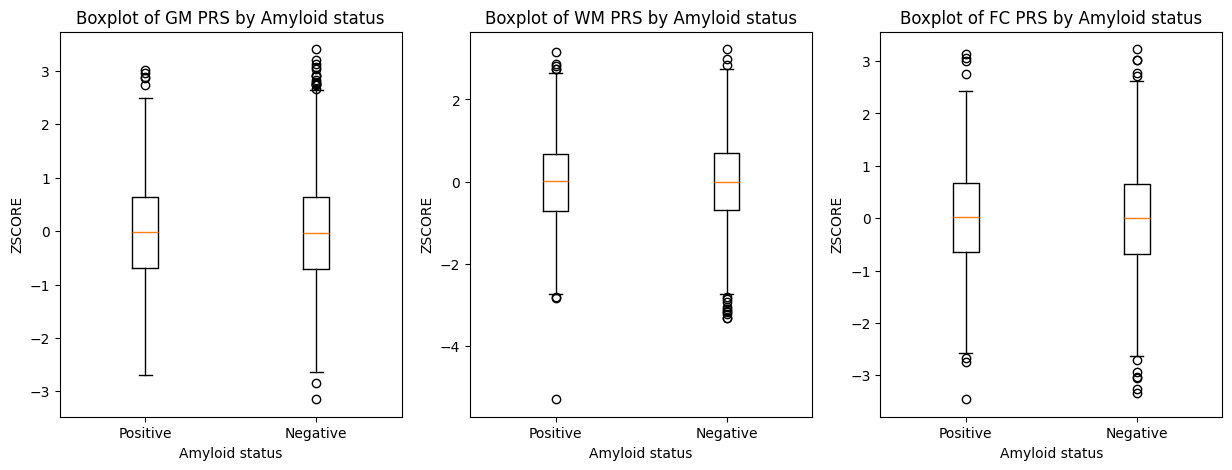

In [8]:
# Obtain subject by amyloid status
df_pos = df_prs[df_prs['BID'].isin(amyl_pos)]
df_neg = df_prs[df_prs['BID'].isin(amyl_neg)]

# Number of positive and negative
print('Number of subjects with positive amyloid status: {}'.format(len(df_pos)))
print('Number of subjects with negative amyloid status: {}'.format(len(df_neg)))

# Plot boxplots for each PRS type for each status in one figure
plt.figure(figsize=(15, 5))

for prs in prs_types:
    # Obtain prs
    pos_prs = df_pos['{}_ZSCORE'.format(prs)].dropna().to_numpy()
    neg_prs = df_neg['{}_ZSCORE'.format(prs)].dropna().to_numpy()
    print('Mean {} PRS for positive amyloid status: {}'.format(prs, pos_prs.mean()))
    print('Mean {} PRS for negative amyloid status: {}'.format(prs, neg_prs.mean()))

    # Caclulate t-test
    t_stat, p_val = ttest_ind(pos_prs, neg_prs)
    print('T-test for {} PRS: t_stat: {}, p_val: {}'.format(prs, t_stat, p_val))

    # Plot boxplot
    plt.subplot(1, 3, prs_types.index(prs) + 1)
    plt.boxplot([pos_prs, neg_prs])
    plt.title('Boxplot of {} PRS by Amyloid status'.format(prs))
    plt.xlabel('Amyloid status')
    plt.ylabel('ZSCORE')
    plt.xticks([1, 2], ['Positive', 'Negative'])
plt.show()

Number of e4 carriers: 1075
Number of e4 non-carriers: 1075
Mean GM PRS for e4 carriers: -0.011862515923669808
Mean GM PRS for non-e4 carriers: -0.011862515923669808
T-test for GM PRS: t_stat: 0.0, p_val: 1.0
Mean WM PRS for e4 carriers: -0.01590601026241491
Mean WM PRS for non-e4 carriers: -0.01590601026241491
T-test for WM PRS: t_stat: 0.0, p_val: 1.0
Mean FC PRS for e4 carriers: -0.000641003905553899
Mean FC PRS for non-e4 carriers: -0.000641003905553899
T-test for FC PRS: t_stat: 0.0, p_val: 1.0


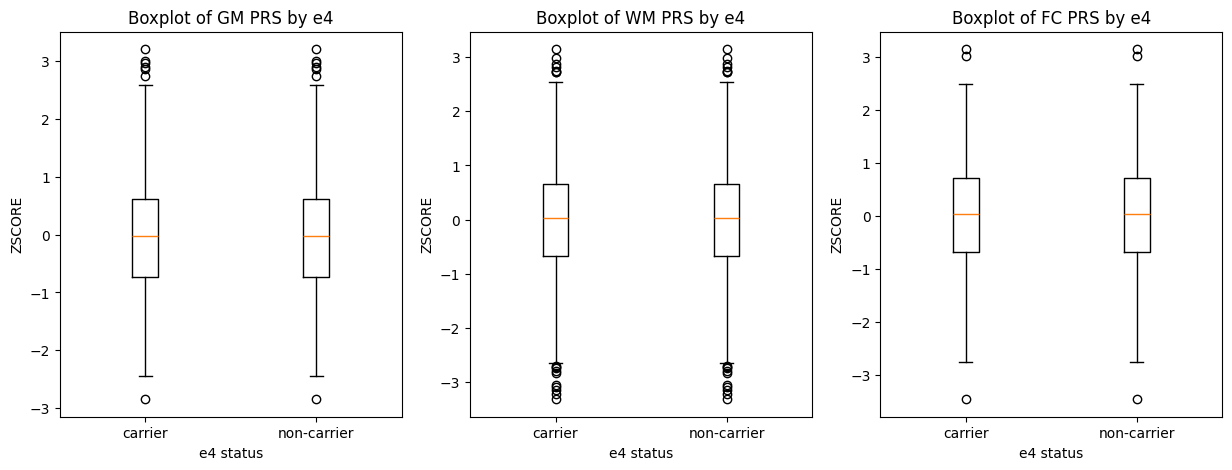

In [9]:
# Obtain subject by amyloid status
df_pos = df_prs[df_prs['BID'].isin(e4_pos)]
df_neg = df_prs[df_prs['BID'].isin(e4_neg)]

# Number of positive and negative
print('Number of e4 carriers: {}'.format(len(df_pos)))
print('Number of e4 non-carriers: {}'.format(len(df_neg)))

# Plot boxplots for each PRS type for each status in one figure
plt.figure(figsize=(15, 5))

for prs in prs_types:
    # Obtain prs
    pos_prs = df_pos['{}_ZSCORE'.format(prs)].dropna().to_numpy()
    neg_prs = df_neg['{}_ZSCORE'.format(prs)].dropna().to_numpy()
    print('Mean {} PRS for e4 carriers: {}'.format(prs, pos_prs.mean()))
    print('Mean {} PRS for non-e4 carriers: {}'.format(prs, neg_prs.mean()))

    # Caclulate t-test
    t_stat, p_val = ttest_ind(pos_prs, neg_prs)
    print('T-test for {} PRS: t_stat: {}, p_val: {}'.format(prs, t_stat, p_val))

    # Plot boxplot
    plt.subplot(1, 3, prs_types.index(prs) + 1)
    plt.boxplot([pos_prs, neg_prs])
    plt.title('Boxplot of {} PRS by e4'.format(prs))
    plt.xlabel('e4 status')
    plt.ylabel('ZSCORE')
    plt.xticks([1, 2], ['carrier', 'non-carrier'])
plt.show()